# PathCond — CIFAR-10 Demo

This notebook demonstrates **PathCond** (Path-Conditioned Training), a method that exploits the **neuron-wise rescaling symmetry** of ReLU networks to improve training.

We apply PathCond **once at initialization** (the *init regime*) and compare against a vanilla baseline across all training epochs on CIFAR-10.  

The architecture used is the fully-convolutional CIFAR-NV model from [Gitman & Ginsburg, 2017](https://arxiv.org/pdf/1709.08145).

---
**Runtime:** ~3–5 min on CPU, ~1 min on GPU (5 epochs)

In [15]:
import copy
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import time

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from pathcond.pathcond import rescaling_path_cond

SEED   = 0
torch.manual_seed(SEED)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {DEVICE}')

Using device: cuda


## 1. Sanity check — PathCond preserves the input-output mapping

Before anything else, we verify the fundamental invariance property of PathCond.

In [16]:
demo = nn.Sequential(
    nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(),
    nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(),
    nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
).to(DEVICE)

x = torch.randn(4, 3, 32, 32, device=DEVICE)
out_before = demo(x).detach().clone()

rescaling_path_cond(demo)

out_after = demo(x).detach()
max_diff  = (out_before - out_after).abs().max().item()

print(f'Max |output| before/after rescaling: {max_diff:.2e}')
if max_diff < 1e-4:
    print('Input-output mapping is numerically preserved.')
else:
    print('Warning: outputs changed significantly — check your model compatibility.')

Max |output| before/after rescaling: 1.56e-07
Input-output mapping is numerically preserved.


## 2. Dataset — CIFAR-10
**No data augmentation** 

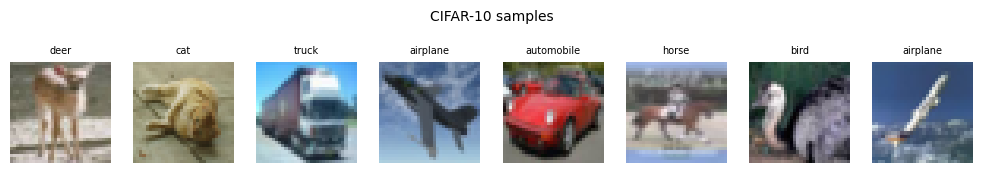

In [3]:
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD  = (0.2023, 0.1994, 0.2010)
CLASSES      = ['airplane','automobile','bird','cat','deer',
                'dog','frog','horse','ship','truck']

def cifar10_loaders(batch_size: int = 128, num_workers: int = 2, seed: int = 0):
    tfm = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
    ])
    torch.manual_seed(seed)
    train_ds = datasets.CIFAR10('./data', train=True,  download=True, transform=tfm)
    test_ds  = datasets.CIFAR10('./data', train=False, download=True, transform=tfm)
    train_dl = DataLoader(train_ds, batch_size=batch_size,   shuffle=True,  num_workers=num_workers, pin_memory=True)
    test_dl  = DataLoader(test_ds,  batch_size=batch_size*2, shuffle=False, num_workers=num_workers, pin_memory=True)
    return train_dl, test_dl

train_dl, test_dl = cifar10_loaders(batch_size=128)

# ── preview a batch ──────────────────────────────────────────────────────────
images, labels = next(iter(DataLoader(
    datasets.CIFAR10('./data', train=True, transform=transforms.ToTensor()),
    batch_size=8, shuffle=True
)))
fig, axes = plt.subplots(1, 8, figsize=(10, 1.6))
for img, lbl, ax in zip(images, labels, axes):
    ax.imshow(img.permute(1, 2, 0).numpy())
    ax.set_title(CLASSES[lbl], fontsize=7)
    ax.axis('off')
plt.suptitle('CIFAR-10 samples', y=1.05, fontsize=10)
plt.tight_layout()
plt.show()

## 3. Model — CIFAR-NV fully convolutional

Architecture from [Gitman & Ginsburg, 2017](https://arxiv.org/pdf/1709.08145): three convolutional blocks with MaxPool, followed by a global average pool.

In [ ]:
class FullyConvolutional(nn.Module):
    """
    CIFAR-NV architecture (Gitman & Ginsburg, 2017).
    """
    def __init__(self, bias: bool = False):
        super().__init__()
        C = lambda i, o, k, s, p: nn.Conv2d(i, o, k, s, p, bias=bias)
        # block 1
        self.block1 = nn.Sequential(
            C(3,   128, 3, 1, 1), nn.ReLU(),
            C(128, 128, 3, 1, 1), nn.ReLU(),
            C(128, 128, 3, 1, 1),
            nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(3, 2, 1),
        )
        # block 2
        self.block2 = nn.Sequential(
            C(128, 256, 3, 1, 1), nn.ReLU(),
            C(256, 256, 3, 1, 1), nn.ReLU(),
            C(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256), nn.ReLU(),
            nn.MaxPool2d(3, 2, 1),
        )
        # block 3 + head
        self.head = nn.Sequential(
            C(256, 320, 3, 1, 1), nn.ReLU(),
            C(320, 320, 1, 1, 0), nn.ReLU(),
            C(320,  10, 1, 1, 0), nn.ReLU(),
            nn.AvgPool2d(8),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.head(self.block2(self.block1(x))).flatten(1)


# count parameters
tmp = FullyConvolutional()
n_params = sum(p.numel() for p in tmp.parameters() if p.requires_grad)
print(f'FullyConvolutional — {n_params:,} trainable parameters')
del tmp

FullyConvolutional — 2,616,576 trainable parameters


## 4. Training

Both models start from **identical weights** (deep copy before any rescaling).  
PathCond is applied **once at initialization** ($t=0$), immediately before the first gradient step.

In [12]:
LR        = 1e-2
NB_EPOCHS = 3
BATCH     = 128

train_dl, test_dl = cifar10_loaders(batch_size=BATCH)

model_baseline = FullyConvolutional().to(DEVICE)
model_pathcond = copy.deepcopy(model_baseline)

print('Applying PathCond rescaling at initialization…')
start = time.time()
rescaling_path_cond(model_pathcond)
end = time.time()
print(f'PathCond rescaling took {end - start:.2f} seconds')
print('Done.')

opt_base = torch.optim.SGD(model_baseline.parameters(), lr=LR)
opt_pc   = torch.optim.SGD(model_pathcond.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

Applying PathCond rescaling at initialization…
PathCond rescaling took 7.47 seconds
Done.


In [13]:
def train_one_epoch(model, loader, criterion, optimizer, device) -> float:
    model.train()
    total_loss, n = 0.0, 0
    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        optimizer.zero_grad()
        loss = criterion(model(x), y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * y.size(0)
        n += y.size(0)
    return total_loss / n


@torch.no_grad()
def evaluate(model, loader, device) -> float:
    model.eval()
    correct, total = 0, 0
    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        correct += (model(x).argmax(1) == y).sum().item()
        total   += y.size(0)
    return correct / total

history = {k: [] for k in ('loss_pc', 'loss_base', 'acc_pc', 'acc_base')}

for epoch in range(1, NB_EPOCHS + 1):
    l_pc   = train_one_epoch(model_pathcond, train_dl, criterion, opt_pc,   DEVICE)
    l_base = train_one_epoch(model_baseline, train_dl, criterion, opt_base, DEVICE)

    a_pc   = evaluate(model_pathcond, test_dl, DEVICE)
    a_base = evaluate(model_baseline, test_dl, DEVICE)

    for key, val in zip(history, [l_pc, l_base, a_pc, a_base]):
        history[key].append(val)

    print(f'Epoch {epoch:3d}/{NB_EPOCHS} │ '
          f'PathCond  loss {l_pc:.4f}  acc {a_pc:.3f} │ '
          f'Baseline  loss {l_base:.4f}  acc {a_base:.3f}')

print(f'\nFinal test accuracy  →  PathCond: {history["acc_pc"][-1]:.4f}   Baseline: {history["acc_base"][-1]:.4f}')

Epoch   1/3 │ PathCond  loss 1.9654  acc 0.347 │ Baseline  loss 2.0300  acc 0.178
Epoch   2/3 │ PathCond  loss 1.4189  acc 0.497 │ Baseline  loss 1.6178  acc 0.484
Epoch   3/3 │ PathCond  loss 1.1720  acc 0.575 │ Baseline  loss 1.2500  acc 0.401

Final test accuracy  →  PathCond: 0.5747   Baseline: 0.4012


## 5. Results

The plots below show training loss and test accuracy per epoch for both models.

**What to look for:**
- A better training dynamics for the Pathcond curve, lower training loss and hopefully a higher test accuracy


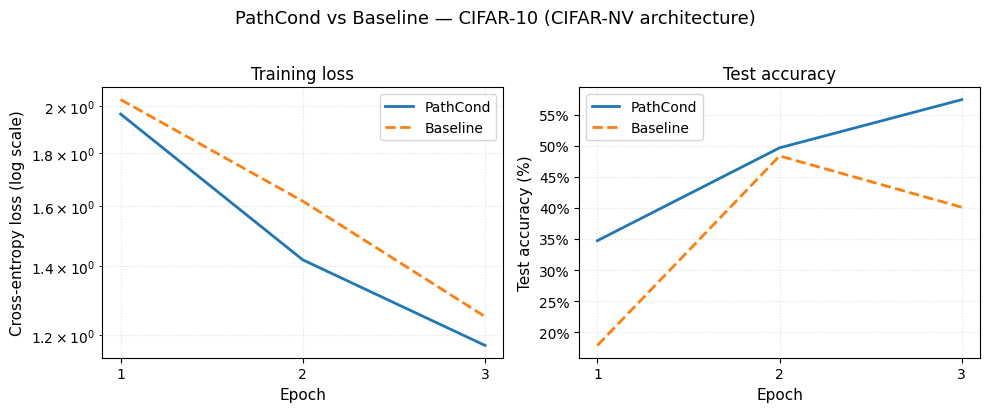

Figure saved → pathcond_cifar10.pdf


In [14]:
epochs     = np.arange(1, NB_EPOCHS + 1)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ax = axes[0]
ax.semilogy(epochs, history['loss_pc'],    lw=2,   label='PathCond')
ax.semilogy(epochs, history['loss_base'],  lw=2, ls='--', label='Baseline')
ax.set_xlabel('Epoch', fontsize=11)
ax.set_ylabel('Cross-entropy loss (log scale)', fontsize=11)
ax.set_title('Training loss', fontsize=12)
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.legend(fontsize=10)
ax.grid(True, which='both', ls=':', alpha=0.4)

ax = axes[1]
ax.plot(epochs, [a * 100 for a in history['acc_pc']], lw=2,   label='PathCond')
ax.plot(epochs, [a * 100 for a in history['acc_base']], lw=2, ls='--', label='Baseline')
ax.set_xlabel('Epoch', fontsize=11)
ax.set_ylabel('Test accuracy (%)', fontsize=11)
ax.set_title('Test accuracy', fontsize=12)
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%d%%'))
ax.legend(fontsize=10)
ax.grid(True, which='both', ls=':', alpha=0.4)

fig.suptitle('PathCond vs Baseline — CIFAR-10 (CIFAR-NV architecture)', fontsize=13, y=1.02)
plt.tight_layout()
plt.show()